In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import optuna
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('src/data.csv')

In [3]:
RANDOM_STATE = 42

TRAIN_SIZE = 0.6
VAL_SIZE = 0.15
TEST_SIZE = 0.25

TARGET = 'attr_value_name'

In [4]:
def calc_metrics(
        model: LogisticRegression,
        vect: CountVectorizer | TfidfVectorizer,
        sample_part: str = 'test',
        multi_class: str = 'ovr',
        descr_column: str = 'description'
):
    """Функция для расчета метрики
    """
    descr_vect = vect.transform(df.loc[df['sample_part'] == sample_part, descr_column])
    proba = model.predict_proba(descr_vect)
    prediction = model.predict(descr_vect)
    target = df.loc[df['sample_part'] == sample_part, TARGET]

    auc_macro = roc_auc_score(
        y_score=proba,
        y_true=target,
        average='macro',
        multi_class=multi_class
    )
    auc_micro = roc_auc_score(
        y_score=proba,
        y_true=target,
        average='micro',
        multi_class=multi_class
    )

    accuracy = accuracy_score(
        y_pred=prediction,
        y_true=target
    )

    print(f'Metrics on {sample_part}:\n'
          f'\tAUC (macro): {auc_macro:.3f}\n'
          f'\tAUC (micro): {auc_micro:.3f}\n'
          f'\tAccuracy: {accuracy:.3f}\n')

Разбиение выборки

In [5]:
df_splitting = pd.read_csv('splitting_sample.csv')
df = df.merge(df_splitting, on='item_id', how='left')

Подгружаем разметку базелином

In [6]:
df_baseline = pd.read_csv('baseline_prediction.csv')
df = df.merge(df_baseline, on='item_id', how='left')

# Отделяем квартиры от домов

In [7]:
SUBSTRINGS_TO_REPLACE = [',', ' в', ' и', ' га', '-студия', '-студии']
WORDS_TO_DELETE = ['на', 'участке', 'доля', 'аукцион:']
SUBWORD_TO_DELETE = ['м²', 'сот.', '-к'] + [str(i) for i in range(10)]

def clear_description(descr: str):
    for substr in SUBSTRINGS_TO_REPLACE:
        descr = descr.replace(substr, '')
    descr = descr.lower().split(' ')
    result = []

    for word in descr:
        cnt_bad_subwords = 0
        for stop_subwords in SUBWORD_TO_DELETE:
            if stop_subwords in word:
                cnt_bad_subwords += 1
        if (word not in WORDS_TO_DELETE) and (cnt_bad_subwords == 0):
            result.append(word)
    
    return ' '.join(result)


descr_train = df.loc[df['sample_part'] == 'train', 'title'].apply(lambda descr: clear_description(descr))
descr_train.value_counts()

title
квартира            86623
дом                 23645
дача                 4366
коттедж              2194
апартаменты          1792
таунхаус              593
своб. планировка      195
квартире              195
своб. планировке        3
Name: count, dtype: int64

In [8]:
def classification_adv(descr: str):
    clear_desc = clear_description(descr)
    if clear_desc in {'квартира', 'квартире', 'своб. планировка', 'своб. планировке'}:
        return 'квартира'
    elif clear_desc in {'апартаменты'}:
        return 'апартаменты'
    elif clear_desc in {'дом'}:
        return 'дом'
    elif clear_desc in {'дача'}:
        return 'дача'
    elif clear_desc in {'коттедж'}:
        return 'коттедж'
    elif clear_desc in {'таунхаус'}:
        return 'таунхаус'
    
df['object_type'] = df['title'].apply(lambda descr: classification_adv(descr))
df['object_type'].value_counts()

object_type
квартира       145114
дом             39422
дача             7253
коттедж          3605
апартаменты      2980
таунхаус          970
Name: count, dtype: int64

# BoW (без предобработки теста)

In [9]:
russian_stopwords = stopwords.words("russian")
russian_stopwords[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [10]:
bow_vect = CountVectorizer(
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    stop_words=russian_stopwords,
    token_pattern='(?u)\\b\\w\\w+\\b',
    ngram_range=(1, 3),
    analyzer='word',
    max_df=1.0,
    min_df=100,
    max_features=None
)

bow_vect.fit(df.loc[df['sample_part'] == 'train', 'description'])

CountVectorizer(min_df=100, ngram_range=(1, 3),
                stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
                            'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                            'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
                            'по', 'только', 'ее', 'мне', ...])

In [11]:
len(bow_vect.vocabulary_)

17449

Обучаем логрег

In [12]:
lr_bow = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=500,
    n_jobs=-1,
    multi_class='ovr'
)

lr_bow.fit(
    X=bow_vect.transform(df.loc[df['sample_part'] == 'train', 'description']),
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

LogisticRegression(max_iter=500, multi_class='ovr', n_jobs=-1, random_state=42)

In [13]:
calc_metrics(
    model=lr_bow,
    vect=bow_vect,
    sample_part='test'
)

Metrics on test:
	AUC (macro): 0.818
	AUC (micro): 0.856
	Accuracy: 0.632



Неплохо.. Во всяком случае базелин побит

# TF-IDF (без предобработки текста)

In [14]:
tfidf_vect = TfidfVectorizer(
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    stop_words=russian_stopwords,
    token_pattern='(?u)\\b\\w\\w+\\b',
    ngram_range=(1, 3),
    analyzer='word',
    max_df=1.0,
    min_df=100,
    max_features=None,
    norm='l2'
)

tfidf_vect.fit(df.loc[df['sample_part'] == 'train', 'description'])
len(tfidf_vect.vocabulary_)

17449

Логрег

In [15]:
lr_tfidf = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=500,
    n_jobs=-1,
    multi_class='ovr'
)

lr_tfidf.fit(
    X=tfidf_vect.transform(df.loc[df['sample_part'] == 'train', 'description']),
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

LogisticRegression(max_iter=500, multi_class='ovr', n_jobs=-1, random_state=42)

In [16]:
calc_metrics(
    model=lr_tfidf,
    vect=tfidf_vect,
    sample_part='test'
)

Metrics on test:
	AUC (macro): 0.855
	AUC (micro): 0.883
	Accuracy: 0.668



In [17]:
# сохраняем предсказания
df['tfidf_lr_predict'] = lr_tfidf.predict(tfidf_vect.transform(df['description']))
df['tfidf_lr_proba'] = lr_tfidf.predict_proba(tfidf_vect.transform(df['description'])).max(axis=1)

Есть улучшения

## Отбираем только уверенные предсказания

/opt/homebrew/Caskroom/miniconda/base/envs/base_env/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning:

Mean of empty slice.

/opt/homebrew/Caskroom/miniconda/base/envs/base_env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide



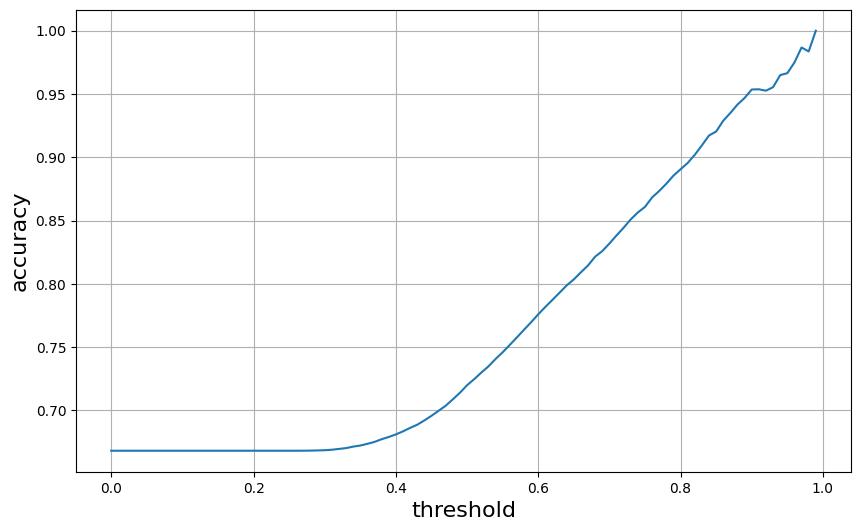

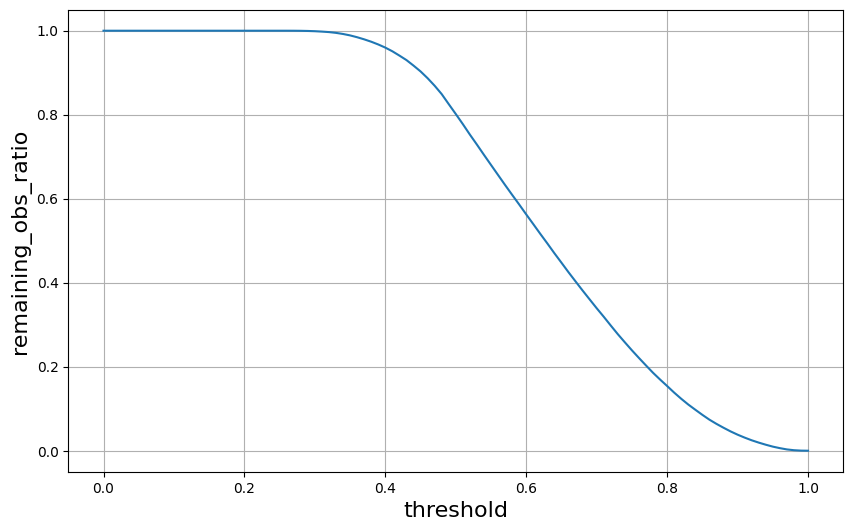

In [62]:
mask_test = df['sample_part'] == 'test'

threshold_list = []
accuracy_list = []
remaining_obs_ratio_list = []
for threshold in np.linspace(0, 1, 101):
    mask_confident_predictions = df['tfidf_lr_proba'] > threshold

    accuracy_confident = accuracy_score(
        y_pred=df.loc[mask_test & mask_confident_predictions, 'tfidf_lr_predict'],
        y_true=df.loc[mask_test & mask_confident_predictions, 'attr_value_name']
    )
    threshold_list.append(threshold)
    accuracy_list.append(accuracy_confident)
    remaining_obs_ratio_list.append(mask_confident_predictions.mean())

# зависимость accuracy от трешхолда
fig = plt.figure(figsize=(10, 6))
plt.plot(threshold_list, accuracy_list)
plt.xlabel('threshold', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
plt.grid()
plt.show()

# зависимость accuracy от трешхолда
fig = plt.figure(figsize=(10, 6))
plt.plot(threshold_list, remaining_obs_ratio_list)
plt.xlabel('threshold', fontsize=16)
plt.ylabel('remaining_obs_ratio', fontsize=16)
plt.grid()
plt.show()

In [63]:
threshold = 0.5
mask_test = df['sample_part'] == 'test'
mask_confident_predictions = df['tfidf_lr_proba'] > threshold

accuracy_confident = accuracy_score(
    y_pred=df.loc[mask_test & mask_confident_predictions, 'tfidf_lr_predict'],
    y_true=df.loc[mask_test & mask_confident_predictions, 'attr_value_name']
)
accuracy_non_confident = accuracy_score(
    y_pred=df.loc[mask_test & ~mask_confident_predictions, 'tfidf_lr_predict'],
    y_true=df.loc[mask_test & ~mask_confident_predictions, 'attr_value_name']
)

print(f"""Доля уверенных предсказаний: {mask_confident_predictions.mean():.3f}""")
print(f"""accuracy по уверенным предсказаниям: {accuracy_confident:.3f}""")
print(f"""accuracy по неуверенным предсказаниям: {accuracy_non_confident:.3f}""")

Доля уверенных предсказаний: 0.802
accuracy по уверенным предсказаниям: 0.720
accuracy по неуверенным предсказаниям: 0.467


Пока оставим с границей 0.5

# TF-IDF (со стеммингом)

In [64]:
tfidf_stem_vect = TfidfVectorizer(
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    stop_words=russian_stopwords,
    token_pattern='(?u)\\b\\w\\w+\\b',
    ngram_range=(1, 3),
    analyzer='word',
    max_df=1.0,
    min_df=100,
    max_features=None,
    norm='l2'
)

ru_stemmer = SnowballStemmer('russian')
tokenizer = tfidf_stem_vect.build_tokenizer()
text_tokens = [tokenizer(text) for text in tqdm(df['description'].values)]
df['description_stem'] = [
    ' '.join([ru_stemmer.stem(word) for word in text]) for text in tqdm(text_tokens)
    ]

tfidf_stem_vect.fit(df.loc[df['sample_part'] == 'train', 'description_stem'])
len(tfidf_stem_vect.vocabulary_)

100%|██████████| 199344/199344 [06:14<00:00, 532.16it/s]


17852

In [65]:
lr_tfidf_stem = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=500,
    n_jobs=-1,
    multi_class='ovr'
)

lr_tfidf_stem.fit(
    X=tfidf_stem_vect.transform(df.loc[df['sample_part'] == 'train', 'description_stem']),
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

LogisticRegression(max_iter=500, multi_class='ovr', n_jobs=-1, random_state=42)

In [66]:
calc_metrics(
    model=lr_tfidf_stem,
    vect=tfidf_stem_vect,
    sample_part='test',
    descr_column='description_stem'
)

Metrics on test:
	AUC (macro): 0.856
	AUC (micro): 0.883
	Accuracy: 0.669



Значительного увеличения качества по сравнению с обычным TF-IDF нет

In [67]:
# сохраняем предсказания
df['tfidf_stem_lr_predict'] = lr_tfidf_stem.predict(tfidf_stem_vect.transform(df['description_stem']))
df['tfidf_stem_lr_proba'] = lr_tfidf_stem.predict_proba(tfidf_stem_vect.transform(df['description_stem'])).max(axis=1)

/opt/homebrew/Caskroom/miniconda/base/envs/base_env/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning:

Mean of empty slice.

/opt/homebrew/Caskroom/miniconda/base/envs/base_env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide



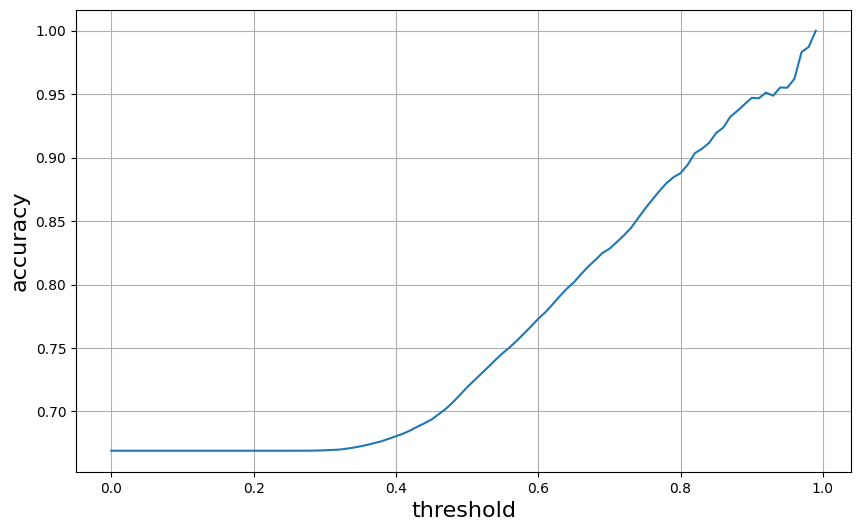

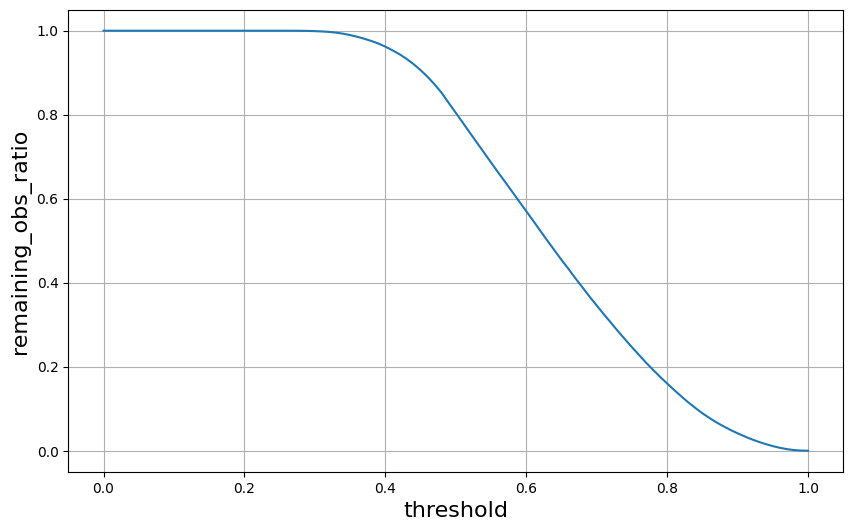

In [68]:
mask_test = df['sample_part'] == 'test'

threshold_list = []
accuracy_list = []
remaining_obs_ratio_list = []
for threshold in np.linspace(0, 1, 101):
    mask_confident_predictions = df['tfidf_stem_lr_proba'] > threshold

    accuracy_confident = accuracy_score(
        y_pred=df.loc[mask_test & mask_confident_predictions, 'tfidf_stem_lr_predict'],
        y_true=df.loc[mask_test & mask_confident_predictions, 'attr_value_name']
    )
    threshold_list.append(threshold)
    accuracy_list.append(accuracy_confident)
    remaining_obs_ratio_list.append(mask_confident_predictions.mean())

# зависимость accuracy от трешхолда
fig = plt.figure(figsize=(10, 6))
plt.plot(threshold_list, accuracy_list)
plt.xlabel('threshold', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
plt.grid()
plt.show()

# зависимость accuracy от трешхолда
fig = plt.figure(figsize=(10, 6))
plt.plot(threshold_list, remaining_obs_ratio_list)
plt.xlabel('threshold', fontsize=16)
plt.ylabel('remaining_obs_ratio', fontsize=16)
plt.grid()
plt.show()

In [70]:
threshold = 0.5
mask_test = df['sample_part'] == 'test'
mask_confident_predictions = df['tfidf_lr_proba'] > threshold

accuracy_confident = accuracy_score(
    y_pred=df.loc[mask_test & mask_confident_predictions, 'tfidf_stem_lr_predict'],
    y_true=df.loc[mask_test & mask_confident_predictions, 'attr_value_name']
)
accuracy_non_confident = accuracy_score(
    y_pred=df.loc[mask_test & ~mask_confident_predictions, 'tfidf_stem_lr_predict'],
    y_true=df.loc[mask_test & ~mask_confident_predictions, 'attr_value_name']
)

print(f"""Доля уверенных предсказаний: {mask_confident_predictions.mean():.3f}""")
print(f"""accuracy по уверенным предсказаниям: {accuracy_confident:.3f}""")
print(f"""accuracy по неуверенным предсказаниям: {accuracy_non_confident:.3f}""")

Доля уверенных предсказаний: 0.802
accuracy по уверенным предсказаниям: 0.716
accuracy по неуверенным предсказаниям: 0.486


+- то же самое, что и без стемминга

# TFIDF (без предобработки текста) + бустинг

In [71]:
tfidf_vect = TfidfVectorizer(
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    stop_words=russian_stopwords,
    token_pattern='(?u)\\b\\w\\w+\\b',
    ngram_range=(1, 3),
    analyzer='word',
    max_df=1.0,
    min_df=100,
    max_features=5000, # устанавливаем ограничение (иначе бустинг может не переварить много фичей)
    norm='l2'
)

tfidf_vect.fit(df.loc[df['sample_part'] == 'train', 'description'])
len(tfidf_vect.vocabulary_)

5000

## Без тюнинга гиперпараметров

In [72]:
clf_boost = lgb.LGBMClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)
clf_boost.fit(
    X=tfidf_vect.transform(df.loc[df['sample_part'] == 'train', 'description']),
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1)

In [73]:
calc_metrics(
    model=clf_boost,
    vect=tfidf_vect,
    sample_part='test',
    descr_column='description'
)

Metrics on test:
	AUC (macro): 0.854
	AUC (micro): 0.882
	Accuracy: 0.663



Результаты чуть хуже

## После тюнинга

In [113]:
BASE_PARAMS = {
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbose': -1
}
TRAIN_SAMPLES = np.sum(df['sample_part'] == 'train')

TRAIN_DATA_TFIDF = tfidf_vect.transform(df.loc[df['sample_part'] == 'train', 'description'])
VAL_DATA_TFIDF = tfidf_vect.transform(df.loc[df['sample_part'] == 'val', 'description'])
TRAIN_TARGET_DATA = df.loc[df['sample_part'] == 'train', TARGET]
VAL_TARGET_DATA = df.loc[df['sample_part'] == 'val', TARGET]

def objective(trial):
    params = {**BASE_PARAMS}
    params['classifier'] = trial.suggest_categorical('classifier', ['gbdt', 'rf'])
    params['learning_rate'] = trial.suggest_float('learning_rate', 1e-3, 5e-1, log=True)
    params['n_estimators'] = trial.suggest_int('n_estimators', 100, 500)
    params['min_child_samples'] = trial.suggest_int('min_child_samples', 0.01 * TRAIN_SAMPLES, 0.2 * TRAIN_SAMPLES)

    clf = lgb.LGBMClassifier(**params)
    clf.fit(
        X=TRAIN_DATA_TFIDF,
        y=TRAIN_TARGET_DATA,
        eval_set=(
            (VAL_DATA_TFIDF, VAL_TARGET_DATA)
        ),
        eval_metric='logloss',
        callbacks=[lgb.early_stopping(30)]
    )

    return roc_auc_score(
        y_score=clf.predict_proba(VAL_DATA_TFIDF),
        y_true=VAL_TARGET_DATA,
        average='macro',
        multi_class='ovr'
    )

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-05-11 11:56:46,883] A new study created in memory with name: no-name-eaa5478d-23e1-410b-addd-2095dbc260f6


Training until validation scores don't improve for 30 rounds


[I 2024-05-11 11:56:48,900] Trial 0 finished with value: 0.6449324210628906 and parameters: {'classifier': 'rf', 'learning_rate': 0.0063859850056025395, 'n_estimators': 126, 'min_child_samples': 14508}. Best is trial 0 with value: 0.6449324210628906.


Did not meet early stopping. Best iteration is:
[126]	valid_0's multi_logloss: 1.19679
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[355]	valid_0's multi_logloss: 1.16419


[I 2024-05-11 11:56:53,325] Trial 1 finished with value: 0.6612650295668818 and parameters: {'classifier': 'rf', 'learning_rate': 0.017121831199215787, 'n_estimators': 355, 'min_child_samples': 18637}. Best is trial 1 with value: 0.6612650295668818.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[392]	valid_0's multi_logloss: 1.07827


[I 2024-05-11 11:57:04,386] Trial 2 finished with value: 0.7337141078802745 and parameters: {'classifier': 'gbdt', 'learning_rate': 0.01357570257603766, 'n_estimators': 392, 'min_child_samples': 9459}. Best is trial 2 with value: 0.7337141078802745.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[153]	valid_0's multi_logloss: 1.17048


[I 2024-05-11 11:57:14,089] Trial 3 finished with value: 0.7437253282893505 and parameters: {'classifier': 'gbdt', 'learning_rate': 0.002025238056093132, 'n_estimators': 153, 'min_child_samples': 4499}. Best is trial 3 with value: 0.7437253282893505.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[263]	valid_0's multi_logloss: 1.17319


[I 2024-05-11 11:57:16,996] Trial 4 finished with value: 0.6520179486643869 and parameters: {'classifier': 'rf', 'learning_rate': 0.4129595687969674, 'n_estimators': 263, 'min_child_samples': 23363}. Best is trial 3 with value: 0.7437253282893505.


Training until validation scores don't improve for 30 rounds


[I 2024-05-11 11:57:20,047] Trial 5 finished with value: 0.7048299024907091 and parameters: {'classifier': 'gbdt', 'learning_rate': 0.004736909678366991, 'n_estimators': 113, 'min_child_samples': 7896}. Best is trial 3 with value: 0.7437253282893505.


Did not meet early stopping. Best iteration is:
[113]	valid_0's multi_logloss: 1.17268
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[210]	valid_0's multi_logloss: 1.17373


[I 2024-05-11 11:57:22,559] Trial 6 finished with value: 0.6511717058816979 and parameters: {'classifier': 'rf', 'learning_rate': 0.028161207314395257, 'n_estimators': 210, 'min_child_samples': 21415}. Best is trial 3 with value: 0.7437253282893505.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[281]	valid_0's multi_logloss: 1.17813


[I 2024-05-11 11:57:25,562] Trial 7 finished with value: 0.64638795021617 and parameters: {'classifier': 'gbdt', 'learning_rate': 0.056506679322315456, 'n_estimators': 281, 'min_child_samples': 22771}. Best is trial 3 with value: 0.7437253282893505.


Training until validation scores don't improve for 30 rounds


[I 2024-05-11 11:57:28,026] Trial 8 finished with value: 0.6273686483762968 and parameters: {'classifier': 'gbdt', 'learning_rate': 0.008038747525815463, 'n_estimators': 229, 'min_child_samples': 23708}. Best is trial 3 with value: 0.7437253282893505.


Did not meet early stopping. Best iteration is:
[229]	valid_0's multi_logloss: 1.20031
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.993483


[I 2024-05-11 11:57:44,667] Trial 9 finished with value: 0.7996755988744879 and parameters: {'classifier': 'rf', 'learning_rate': 0.014943231980725766, 'n_estimators': 100, 'min_child_samples': 2081}. Best is trial 9 with value: 0.7996755988744879.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[426]	valid_0's multi_logloss: 0.881205


[I 2024-05-11 11:58:38,920] Trial 10 finished with value: 0.8301798518837558 and parameters: {'classifier': 'rf', 'learning_rate': 0.09879924734252413, 'n_estimators': 427, 'min_child_samples': 2367}. Best is trial 10 with value: 0.8301798518837558.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[266]	valid_0's multi_logloss: 0.838754


[I 2024-05-11 11:59:47,970] Trial 11 finished with value: 0.8464785448415664 and parameters: {'classifier': 'rf', 'learning_rate': 0.12706496718542465, 'n_estimators': 493, 'min_child_samples': 1209}. Best is trial 11 with value: 0.8464785448415664.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[314]	valid_0's multi_logloss: 0.883514


[I 2024-05-11 12:00:30,144] Trial 12 finished with value: 0.8292432146079471 and parameters: {'classifier': 'rf', 'learning_rate': 0.1407580834861623, 'n_estimators': 495, 'min_child_samples': 2419}. Best is trial 11 with value: 0.8464785448415664.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[481]	valid_0's multi_logloss: 0.968965


[I 2024-05-11 12:00:47,361] Trial 13 finished with value: 0.7910227657737864 and parameters: {'classifier': 'rf', 'learning_rate': 0.11318305252404008, 'n_estimators': 481, 'min_child_samples': 6454}. Best is trial 11 with value: 0.8464785448415664.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[422]	valid_0's multi_logloss: 1.0793


[I 2024-05-11 12:00:56,273] Trial 14 finished with value: 0.7243326851300096 and parameters: {'classifier': 'rf', 'learning_rate': 0.3444737636823995, 'n_estimators': 427, 'min_child_samples': 11146}. Best is trial 11 with value: 0.8464785448415664.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[435]	valid_0's multi_logloss: 1.13014


[I 2024-05-11 12:01:02,561] Trial 15 finished with value: 0.6888748650580627 and parameters: {'classifier': 'rf', 'learning_rate': 0.1100446566865574, 'n_estimators': 435, 'min_child_samples': 14348}. Best is trial 11 with value: 0.8464785448415664.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[348]	valid_0's multi_logloss: 0.943763


[I 2024-05-11 12:01:21,755] Trial 16 finished with value: 0.804539839160912 and parameters: {'classifier': 'rf', 'learning_rate': 0.041629465687682395, 'n_estimators': 348, 'min_child_samples': 4841}. Best is trial 11 with value: 0.8464785448415664.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[119]	valid_0's multi_logloss: 0.859148


[I 2024-05-11 12:01:48,878] Trial 17 finished with value: 0.8388856620468028 and parameters: {'classifier': 'rf', 'learning_rate': 0.26047970635539325, 'n_estimators': 436, 'min_child_samples': 1689}. Best is trial 11 with value: 0.8464785448415664.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[368]	valid_0's multi_logloss: 0.926104


[I 2024-05-11 12:02:10,272] Trial 18 finished with value: 0.8111907359403768 and parameters: {'classifier': 'rf', 'learning_rate': 0.26021457559944083, 'n_estimators': 468, 'min_child_samples': 4848}. Best is trial 11 with value: 0.8464785448415664.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[335]	valid_0's multi_logloss: 1.00738


[I 2024-05-11 12:02:37,029] Trial 19 finished with value: 0.7694766017824645 and parameters: {'classifier': 'rf', 'learning_rate': 0.1916113228840156, 'n_estimators': 335, 'min_child_samples': 7964}. Best is trial 11 with value: 0.8464785448415664.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[384]	valid_0's multi_logloss: 1.14304


[I 2024-05-11 12:02:42,423] Trial 20 finished with value: 0.6774032864123813 and parameters: {'classifier': 'rf', 'learning_rate': 0.06147041233302289, 'n_estimators': 384, 'min_child_samples': 17325}. Best is trial 11 with value: 0.8464785448415664.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[366]	valid_0's multi_logloss: 0.836708


[I 2024-05-11 12:04:13,286] Trial 21 finished with value: 0.8472560442891142 and parameters: {'classifier': 'rf', 'learning_rate': 0.0845251495668393, 'n_estimators': 436, 'min_child_samples': 1198}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[222]	valid_0's multi_logloss: 0.841957


[I 2024-05-11 12:05:08,346] Trial 22 finished with value: 0.8453967064790214 and parameters: {'classifier': 'rf', 'learning_rate': 0.17076456620229757, 'n_estimators': 453, 'min_child_samples': 1362}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[461]	valid_0's multi_logloss: 0.920272


[I 2024-05-11 12:05:38,081] Trial 23 finished with value: 0.8141667951796976 and parameters: {'classifier': 'rf', 'learning_rate': 0.07123891299828643, 'n_estimators': 461, 'min_child_samples': 4184}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[392]	valid_0's multi_logloss: 0.853053


[I 2024-05-11 12:07:00,747] Trial 24 finished with value: 0.8413972609948891 and parameters: {'classifier': 'rf', 'learning_rate': 0.037538912934717006, 'n_estimators': 392, 'min_child_samples': 1474}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[424]	valid_0's multi_logloss: 0.910257


[I 2024-05-11 12:07:34,428] Trial 25 finished with value: 0.8179147912231126 and parameters: {'classifier': 'rf', 'learning_rate': 0.18217853391138014, 'n_estimators': 497, 'min_child_samples': 3800}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[276]	valid_0's multi_logloss: 0.99089


[I 2024-05-11 12:07:44,018] Trial 26 finished with value: 0.7779050744926496 and parameters: {'classifier': 'gbdt', 'learning_rate': 0.4367253308876769, 'n_estimators': 455, 'min_child_samples': 7228}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[309]	valid_0's multi_logloss: 0.961727


[I 2024-05-11 12:07:57,202] Trial 27 finished with value: 0.795901960885375 and parameters: {'classifier': 'rf', 'learning_rate': 0.07849733370528558, 'n_estimators': 309, 'min_child_samples': 5888}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[413]	valid_0's multi_logloss: 1.03384


[I 2024-05-11 12:08:06,266] Trial 28 finished with value: 0.7549847369256145 and parameters: {'classifier': 'rf', 'learning_rate': 0.1760260731019712, 'n_estimators': 414, 'min_child_samples': 9775}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[369]	valid_0's multi_logloss: 0.910751


[I 2024-05-11 12:08:40,945] Trial 29 finished with value: 0.8186154704362057 and parameters: {'classifier': 'rf', 'learning_rate': 0.03649078101898754, 'n_estimators': 369, 'min_child_samples': 3057}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[453]	valid_0's multi_logloss: 1.10048


[I 2024-05-11 12:08:48,655] Trial 30 finished with value: 0.709441106944956 and parameters: {'classifier': 'rf', 'learning_rate': 0.2674893813651037, 'n_estimators': 456, 'min_child_samples': 12999}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[401]	valid_0's multi_logloss: 0.841322


[I 2024-05-11 12:10:20,609] Trial 31 finished with value: 0.8456891025159304 and parameters: {'classifier': 'rf', 'learning_rate': 0.039572973107712205, 'n_estimators': 401, 'min_child_samples': 1242}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[415]	valid_0's multi_logloss: 0.926014


[I 2024-05-11 12:10:54,825] Trial 32 finished with value: 0.8126256913390209 and parameters: {'classifier': 'rf', 'learning_rate': 0.023242040824621644, 'n_estimators': 415, 'min_child_samples': 3342}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[402]	valid_0's multi_logloss: 0.841843


[I 2024-05-11 12:12:18,664] Trial 33 finished with value: 0.8454182241590784 and parameters: {'classifier': 'rf', 'learning_rate': 0.05032095978923391, 'n_estimators': 402, 'min_child_samples': 1373}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[322]	valid_0's multi_logloss: 1.01702


[I 2024-05-11 12:12:33,736] Trial 34 finished with value: 0.7770116461356362 and parameters: {'classifier': 'rf', 'learning_rate': 0.009191412919889334, 'n_estimators': 322, 'min_child_samples': 5540}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[368]	valid_0's multi_logloss: 0.935415


[I 2024-05-11 12:13:03,777] Trial 35 finished with value: 0.809286456651872 and parameters: {'classifier': 'gbdt', 'learning_rate': 0.01922969034749998, 'n_estimators': 368, 'min_child_samples': 3361}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[400]	valid_0's multi_logloss: 0.850014


[I 2024-05-11 12:14:20,466] Trial 36 finished with value: 0.8425062999764602 and parameters: {'classifier': 'rf', 'learning_rate': 0.04965635559015353, 'n_estimators': 400, 'min_child_samples': 1534}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[479]	valid_0's multi_logloss: 1.04932


[I 2024-05-11 12:14:32,448] Trial 37 finished with value: 0.747723901445691 and parameters: {'classifier': 'rf', 'learning_rate': 0.02736328348165096, 'n_estimators': 479, 'min_child_samples': 9004}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[372]	valid_0's multi_logloss: 1.20508


[I 2024-05-11 12:14:37,174] Trial 38 finished with value: 0.6405166368718054 and parameters: {'classifier': 'gbdt', 'learning_rate': 0.001761355298134073, 'n_estimators': 372, 'min_child_samples': 16569}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[406]	valid_0's multi_logloss: 0.921862


[I 2024-05-11 12:15:02,607] Trial 39 finished with value: 0.8133581487868263 and parameters: {'classifier': 'rf', 'learning_rate': 0.0893574062194756, 'n_estimators': 406, 'min_child_samples': 4384}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds


[I 2024-05-11 12:15:04,739] Trial 40 finished with value: 0.625068488688787 and parameters: {'classifier': 'gbdt', 'learning_rate': 0.0010723099980048105, 'n_estimators': 163, 'min_child_samples': 19413}. Best is trial 21 with value: 0.8472560442891142.


Did not meet early stopping. Best iteration is:
[163]	valid_0's multi_logloss: 1.23017
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[278]	valid_0's multi_logloss: 0.839402


[I 2024-05-11 12:16:13,787] Trial 41 finished with value: 0.8461928885178529 and parameters: {'classifier': 'rf', 'learning_rate': 0.12760936652427998, 'n_estimators': 439, 'min_child_samples': 1269}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[441]	valid_0's multi_logloss: 0.899619


[I 2024-05-11 12:16:55,943] Trial 42 finished with value: 0.8228145080574406 and parameters: {'classifier': 'rf', 'learning_rate': 0.0533839506134528, 'n_estimators': 441, 'min_child_samples': 3011}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[372]	valid_0's multi_logloss: 0.883458


[I 2024-05-11 12:17:47,180] Trial 43 finished with value: 0.8293645472114582 and parameters: {'classifier': 'rf', 'learning_rate': 0.13340578597236422, 'n_estimators': 477, 'min_child_samples': 2446}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[476]	valid_0's multi_logloss: 0.838248


[I 2024-05-11 12:19:33,591] Trial 44 finished with value: 0.8466908364985484 and parameters: {'classifier': 'rf', 'learning_rate': 0.0763053344036582, 'n_estimators': 500, 'min_child_samples': 1311}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[482]	valid_0's multi_logloss: 0.939765


[I 2024-05-11 12:19:57,348] Trial 45 finished with value: 0.8053893367230455 and parameters: {'classifier': 'rf', 'learning_rate': 0.08080198812119041, 'n_estimators': 482, 'min_child_samples': 5443}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[493]	valid_0's multi_logloss: 0.928385


[I 2024-05-11 12:20:48,944] Trial 46 finished with value: 0.8131209540995294 and parameters: {'classifier': 'rf', 'learning_rate': 0.011476666039528939, 'n_estimators': 493, 'min_child_samples': 2779}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[448]	valid_0's multi_logloss: 1.08468


[I 2024-05-11 12:21:03,434] Trial 47 finished with value: 0.7387836020059072 and parameters: {'classifier': 'rf', 'learning_rate': 0.00448597608450067, 'n_estimators': 448, 'min_child_samples': 6702}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's multi_logloss: 0.909075


[I 2024-05-11 12:21:40,677] Trial 48 finished with value: 0.8186361303686626 and parameters: {'classifier': 'gbdt', 'learning_rate': 0.1038180242742693, 'n_estimators': 500, 'min_child_samples': 3802}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[253]	valid_0's multi_logloss: 0.906821


[I 2024-05-11 12:22:11,516] Trial 49 finished with value: 0.8212025685239088 and parameters: {'classifier': 'rf', 'learning_rate': 0.0307566292189543, 'n_estimators': 253, 'min_child_samples': 2401}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[239]	valid_0's multi_logloss: 0.839307


[I 2024-05-11 12:23:12,274] Trial 50 finished with value: 0.8462549886439586 and parameters: {'classifier': 'rf', 'learning_rate': 0.12830071086125808, 'n_estimators': 470, 'min_child_samples': 1201}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[252]	valid_0's multi_logloss: 0.838737


[I 2024-05-11 12:24:17,843] Trial 51 finished with value: 0.8465172748415583 and parameters: {'classifier': 'rf', 'learning_rate': 0.13926866395499107, 'n_estimators': 471, 'min_child_samples': 1229}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[242]	valid_0's multi_logloss: 0.866675


[I 2024-05-11 12:24:59,534] Trial 52 finished with value: 0.8361236526051176 and parameters: {'classifier': 'rf', 'learning_rate': 0.14042370587065567, 'n_estimators': 469, 'min_child_samples': 1980}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 0.88782


[I 2024-05-11 12:25:22,561] Trial 53 finished with value: 0.8275814082261055 and parameters: {'classifier': 'rf', 'learning_rate': 0.32352156648242636, 'n_estimators': 425, 'min_child_samples': 2353}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[477]	valid_0's multi_logloss: 0.916269


[I 2024-05-11 12:25:56,418] Trial 54 finished with value: 0.8156263045122107 and parameters: {'classifier': 'rf', 'learning_rate': 0.11983591121865944, 'n_estimators': 484, 'min_child_samples': 4189}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[439]	valid_0's multi_logloss: 0.924037


[I 2024-05-11 12:26:23,676] Trial 55 finished with value: 0.8119031314967072 and parameters: {'classifier': 'rf', 'learning_rate': 0.20807815278439903, 'n_estimators': 467, 'min_child_samples': 4899}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[301]	valid_0's multi_logloss: 0.900315


[I 2024-05-11 12:26:54,960] Trial 56 finished with value: 0.8220468904717211 and parameters: {'classifier': 'rf', 'learning_rate': 0.22909174385292286, 'n_estimators': 433, 'min_child_samples': 3167}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[446]	valid_0's multi_logloss: 0.8678


[I 2024-05-11 12:27:59,192] Trial 57 finished with value: 0.8358199808522881 and parameters: {'classifier': 'rf', 'learning_rate': 0.06436652593890112, 'n_estimators': 446, 'min_child_samples': 2076}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[467]	valid_0's multi_logloss: 0.910289


[I 2024-05-11 12:28:35,167] Trial 58 finished with value: 0.8180686993990425 and parameters: {'classifier': 'rf', 'learning_rate': 0.09477213231741988, 'n_estimators': 467, 'min_child_samples': 3830}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.848704


[I 2024-05-11 12:28:59,868] Trial 59 finished with value: 0.8428363630134263 and parameters: {'classifier': 'rf', 'learning_rate': 0.36138099336025464, 'n_estimators': 487, 'min_child_samples': 1287}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[498]	valid_0's multi_logloss: 0.924521


[I 2024-05-11 12:29:27,342] Trial 60 finished with value: 0.8117128935254097 and parameters: {'classifier': 'rf', 'learning_rate': 0.14686541024386865, 'n_estimators': 498, 'min_child_samples': 4897}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[418]	valid_0's multi_logloss: 0.88066


[I 2024-05-11 12:30:25,491] Trial 61 finished with value: 0.8304317262884022 and parameters: {'classifier': 'rf', 'learning_rate': 0.06965934475402916, 'n_estimators': 418, 'min_child_samples': 2225}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[441]	valid_0's multi_logloss: 0.83968


[I 2024-05-11 12:32:02,561] Trial 62 finished with value: 0.8462070901204178 and parameters: {'classifier': 'rf', 'learning_rate': 0.04453237738175344, 'n_estimators': 441, 'min_child_samples': 1264}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[345]	valid_0's multi_logloss: 0.893838


[I 2024-05-11 12:32:42,705] Trial 63 finished with value: 0.8248938334178695 and parameters: {'classifier': 'rf', 'learning_rate': 0.1549892464911826, 'n_estimators': 445, 'min_child_samples': 2924}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[331]	valid_0's multi_logloss: 0.838528


[I 2024-05-11 12:34:01,286] Trial 64 finished with value: 0.8465635286546755 and parameters: {'classifier': 'rf', 'learning_rate': 0.10319278592992998, 'n_estimators': 462, 'min_child_samples': 1249}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[452]	valid_0's multi_logloss: 0.865696


[I 2024-05-11 12:35:08,859] Trial 65 finished with value: 0.8364215746553798 and parameters: {'classifier': 'rf', 'learning_rate': 0.10146471896227925, 'n_estimators': 462, 'min_child_samples': 2031}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[479]	valid_0's multi_logloss: 0.9094


[I 2024-05-11 12:35:45,469] Trial 66 finished with value: 0.818677398559303 and parameters: {'classifier': 'rf', 'learning_rate': 0.0794299536418775, 'n_estimators': 479, 'min_child_samples': 3652}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[208]	valid_0's multi_logloss: 0.908982


[I 2024-05-11 12:36:09,497] Trial 67 finished with value: 0.819830130916702 and parameters: {'classifier': 'gbdt', 'learning_rate': 0.04668089775303624, 'n_estimators': 208, 'min_child_samples': 2718}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[454]	valid_0's multi_logloss: 1.17511


[I 2024-05-11 12:36:14,573] Trial 68 finished with value: 0.6495173736259539 and parameters: {'classifier': 'rf', 'learning_rate': 0.059848423624822567, 'n_estimators': 454, 'min_child_samples': 22145}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[137]	valid_0's multi_logloss: 0.870734


[I 2024-05-11 12:36:41,597] Trial 69 finished with value: 0.8345514973905014 and parameters: {'classifier': 'rf', 'learning_rate': 0.24085790645591384, 'n_estimators': 288, 'min_child_samples': 1992}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[471]	valid_0's multi_logloss: 1.06526


[I 2024-05-11 12:36:51,259] Trial 70 finished with value: 0.7359104314934715 and parameters: {'classifier': 'rf', 'learning_rate': 0.11448874056562837, 'n_estimators': 471, 'min_child_samples': 10760}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[311]	valid_0's multi_logloss: 0.847366


[I 2024-05-11 12:37:58,492] Trial 71 finished with value: 0.8433073301221032 and parameters: {'classifier': 'rf', 'learning_rate': 0.13136863836867288, 'n_estimators': 433, 'min_child_samples': 1424}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[182]	valid_0's multi_logloss: 0.841077


[I 2024-05-11 12:38:44,120] Trial 72 finished with value: 0.8455246765730526 and parameters: {'classifier': 'rf', 'learning_rate': 0.16478304120839515, 'n_estimators': 489, 'min_child_samples': 1323}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[449]	valid_0's multi_logloss: 0.861131


[I 2024-05-11 12:39:57,074] Trial 73 finished with value: 0.8383351076247043 and parameters: {'classifier': 'rf', 'learning_rate': 0.08582970245182403, 'n_estimators': 457, 'min_child_samples': 1862}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[422]	valid_0's multi_logloss: 0.904286


[I 2024-05-11 12:40:37,205] Trial 74 finished with value: 0.8206871810701923 and parameters: {'classifier': 'rf', 'learning_rate': 0.06581943416543096, 'n_estimators': 422, 'min_child_samples': 3224}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.891358


[I 2024-05-11 12:40:58,475] Trial 75 finished with value: 0.8260399521105058 and parameters: {'classifier': 'rf', 'learning_rate': 0.29340676054996845, 'n_estimators': 442, 'min_child_samples': 2543}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 0.841399


[I 2024-05-11 12:41:38,593] Trial 76 finished with value: 0.8454609585326338 and parameters: {'classifier': 'rf', 'learning_rate': 0.20135696027710268, 'n_estimators': 389, 'min_child_samples': 1252}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's multi_logloss: 0.9183


[I 2024-05-11 12:42:10,604] Trial 77 finished with value: 0.8146976568256644 and parameters: {'classifier': 'rf', 'learning_rate': 0.1218089262153287, 'n_estimators': 500, 'min_child_samples': 4337}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[474]	valid_0's multi_logloss: 1.11791


[I 2024-05-11 12:42:19,324] Trial 78 finished with value: 0.6976566749629624 and parameters: {'classifier': 'gbdt', 'learning_rate': 0.04300195039840065, 'n_estimators': 474, 'min_child_samples': 13200}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[347]	valid_0's multi_logloss: 0.910401


[I 2024-05-11 12:42:46,859] Trial 79 finished with value: 0.8182942022538765 and parameters: {'classifier': 'rf', 'learning_rate': 0.10152358955527589, 'n_estimators': 347, 'min_child_samples': 3592}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[408]	valid_0's multi_logloss: 0.974929


[I 2024-05-11 12:43:04,785] Trial 80 finished with value: 0.7907337894887027 and parameters: {'classifier': 'rf', 'learning_rate': 0.033675879031960294, 'n_estimators': 408, 'min_child_samples': 5977}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[457]	valid_0's multi_logloss: 0.864407


[I 2024-05-11 12:44:27,281] Trial 81 finished with value: 0.837236089801153 and parameters: {'classifier': 'rf', 'learning_rate': 0.02720243135743446, 'n_estimators': 457, 'min_child_samples': 1798}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[432]	valid_0's multi_logloss: 0.89591


[I 2024-05-11 12:45:19,487] Trial 82 finished with value: 0.8245728247934058 and parameters: {'classifier': 'rf', 'learning_rate': 0.04042725222315644, 'n_estimators': 432, 'min_child_samples': 2658}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[458]	valid_0's multi_logloss: 0.837466


[I 2024-05-11 12:47:07,682] Trial 83 finished with value: 0.8469605021667495 and parameters: {'classifier': 'rf', 'learning_rate': 0.07390016600136354, 'n_estimators': 483, 'min_child_samples': 1286}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[479]	valid_0's multi_logloss: 0.855045


[I 2024-05-11 12:48:34,187] Trial 84 finished with value: 0.8405383548500567 and parameters: {'classifier': 'rf', 'learning_rate': 0.077161527377015, 'n_estimators': 484, 'min_child_samples': 1812}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[491]	valid_0's multi_logloss: 0.893787


[I 2024-05-11 12:49:29,734] Trial 85 finished with value: 0.8252679562257661 and parameters: {'classifier': 'rf', 'learning_rate': 0.0525905761564797, 'n_estimators': 491, 'min_child_samples': 2853}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[465]	valid_0's multi_logloss: 1.14402


[I 2024-05-11 12:49:35,312] Trial 86 finished with value: 0.6767227810274963 and parameters: {'classifier': 'rf', 'learning_rate': 0.17497400104151106, 'n_estimators': 465, 'min_child_samples': 19622}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[458]	valid_0's multi_logloss: 0.853782


[I 2024-05-11 12:50:57,419] Trial 87 finished with value: 0.8409021469269728 and parameters: {'classifier': 'rf', 'learning_rate': 0.09205400040059496, 'n_estimators': 476, 'min_child_samples': 1707}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[382]	valid_0's multi_logloss: 0.837701


[I 2024-05-11 12:52:34,753] Trial 88 finished with value: 0.8469190794114492 and parameters: {'classifier': 'rf', 'learning_rate': 0.07213161189476934, 'n_estimators': 452, 'min_child_samples': 1213}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[452]	valid_0's multi_logloss: 0.883239


[I 2024-05-11 12:53:35,058] Trial 89 finished with value: 0.8295559745541738 and parameters: {'classifier': 'rf', 'learning_rate': 0.05897126468783135, 'n_estimators': 453, 'min_child_samples': 2358}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[488]	valid_0's multi_logloss: 1.13534


[I 2024-05-11 12:53:41,774] Trial 90 finished with value: 0.6843114086564056 and parameters: {'classifier': 'gbdt', 'learning_rate': 0.07081712699369587, 'n_estimators': 488, 'min_child_samples': 15494}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[278]	valid_0's multi_logloss: 0.838182


[I 2024-05-11 12:54:54,350] Trial 91 finished with value: 0.8466870103380209 and parameters: {'classifier': 'rf', 'learning_rate': 0.12396861474606151, 'n_estimators': 440, 'min_child_samples': 1217}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[363]	valid_0's multi_logloss: 0.837822


[I 2024-05-11 12:56:28,263] Trial 92 finished with value: 0.8468330873222567 and parameters: {'classifier': 'rf', 'learning_rate': 0.1091319289176196, 'n_estimators': 449, 'min_child_samples': 1217}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[473]	valid_0's multi_logloss: 0.899436


[I 2024-05-11 12:57:26,213] Trial 93 finished with value: 0.8223586745127897 and parameters: {'classifier': 'rf', 'learning_rate': 0.11610543081533581, 'n_estimators': 473, 'min_child_samples': 3266}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[280]	valid_0's multi_logloss: 0.865841


[I 2024-05-11 12:58:19,462] Trial 94 finished with value: 0.8365986859668302 and parameters: {'classifier': 'rf', 'learning_rate': 0.14429296537388686, 'n_estimators': 462, 'min_child_samples': 1944}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[395]	valid_0's multi_logloss: 0.837344


[I 2024-05-11 12:59:53,436] Trial 95 finished with value: 0.846916737455229 and parameters: {'classifier': 'rf', 'learning_rate': 0.08973521591370671, 'n_estimators': 448, 'min_child_samples': 1212}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[450]	valid_0's multi_logloss: 0.881954


[I 2024-05-11 13:00:50,273] Trial 96 finished with value: 0.8298372294144316 and parameters: {'classifier': 'rf', 'learning_rate': 0.08948461639281349, 'n_estimators': 450, 'min_child_samples': 2439}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[414]	valid_0's multi_logloss: 0.912703


[I 2024-05-11 13:01:23,811] Trial 97 finished with value: 0.8172905366690848 and parameters: {'classifier': 'rf', 'learning_rate': 0.07388042279680923, 'n_estimators': 414, 'min_child_samples': 3719}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[309]	valid_0's multi_logloss: 0.855254


[I 2024-05-11 13:02:24,373] Trial 98 finished with value: 0.8404061399662606 and parameters: {'classifier': 'rf', 'learning_rate': 0.10368419997326811, 'n_estimators': 491, 'min_child_samples': 1759}. Best is trial 21 with value: 0.8472560442891142.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[249]	valid_0's multi_logloss: 0.892244


[I 2024-05-11 13:02:53,532] Trial 99 finished with value: 0.8257033301124913 and parameters: {'classifier': 'rf', 'learning_rate': 0.20519331886092454, 'n_estimators': 426, 'min_child_samples': 2815}. Best is trial 21 with value: 0.8472560442891142.


In [116]:
clf_tuned = lgb.LGBMClassifier(**BASE_PARAMS, **study.best_params)
clf_tuned.fit(
    X=TRAIN_DATA_TFIDF,
    y=TRAIN_TARGET_DATA,
    eval_set=(
        (VAL_DATA_TFIDF, VAL_TARGET_DATA)
    ),
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(30)]
)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[366]	valid_0's multi_logloss: 0.836708


LGBMClassifier(classifier='rf', learning_rate=0.0845251495668393,
               min_child_samples=1198, n_estimators=436, n_jobs=-1,
               random_state=42, verbose=-1)

In [117]:
calc_metrics(
    model=clf_tuned,
    vect=tfidf_vect,
    sample_part='test',
    descr_column='description'
)

Metrics on test:
	AUC (macro): 0.846
	AUC (micro): 0.876
	Accuracy: 0.652



**Итог**: оставим TF-IDF без предобработки текста + логистическая регрессия.

Этот подход оптимален с точки зрения хорошего качества + низкой цены инференса

In [123]:
df[['item_id', 'tfidf_lr_predict', 'tfidf_lr_proba']].to_csv('tfidf_lr_prediction.csv', index=False)